In [5]:
import random
import time
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt

import SIFT

from tqdm import tqdm
from sklearn.cluster import KMeans
from scipy.spatial import distance

# Load data from data set and set up
## Run this step before training or testing

In [6]:
plt.set_cmap('gray')

# load images
def load_images_from_folder(folder):
    images = {}
    for cdata in os.listdir(folder):
        # prevent to read something like .DS_store
        if cdata.startswith('.'):
            continue
        current_class = []
        path = folder + "/" + cdata
        for file in os.listdir(path):
            # prevent to read something like .DS_store
            if file.startswith('.'):
                continue
            image = cv2.imread(path + "/" + file)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            if image is not None:
                current_class.append(image)
        images[cdata] = current_class
    return images


# Read from directory
train_set  = load_images_from_folder('COMP338_Assignment1_Dataset/Training')
test_set = load_images_from_folder('COMP338_Assignment1_Dataset/Test')

<Figure size 432x288 with 0 Axes>

# Training process
## Step 1: Extract SIFT Feature

In [7]:
# SIFT Features
def sift_features(images):
    sift_vectors = {}
    keypoint_vectors = {}
    all_descriptor = []
    for image_class, folder in images.items():
        features = []
        keypoint_list = []
        pbar = tqdm(folder, position=0)
        for image in pbar:
            time.sleep(.01)
            pbar.set_description(f"Processing {image_class}", refresh=True)
            key_p, des = SIFT.computeKeypointsAndDescriptors(image)
            all_descriptor.extend(des)
            features.append(des)
            keypoint_list.append(key_p)
        sift_vectors[image_class] = features
        keypoint_vectors[image_class] = keypoint_list
    return [all_descriptor, sift_vectors, keypoint_vectors]


# Only extract first n samples
def slice_dataset(images, n):
    dic = {}
    for image_class, folder in images.items():
        folder = folder[0:n]
        dic[image_class] = folder
    return dic

In [ ]:
# Extract SIFT Features from train-set
# Only use first 2 samples in developing stage
sift_train = sift_features(train_set)

train_des_list = sift_train[0]
train_des_by_class = sift_train[1]
train_kp_by_class = sift_train[2]

Processing airplanes:   7%|▋         | 5/70 [01:05<13:44, 12.69s/it]

In [25]:
# Extract SIFT Features from test-set
sift_test = sift_features(slice_dataset(test_set, 2))

Processing keyboard: 100%|██████████| 2/2 [00:42<00:00, 21.28s/it]


In [ ]:
test_des_by_class = sift_test[1]

## Step 2: Generate dictionary

In [11]:
# Return the cluster center from kmeans algorithm
def kmeans(k, list_descriptor):
    k_means = KMeans(n_clusters = k, n_init=10)
    k_means.fit(list_descriptor)
    visual_words = k_means.cluster_centers_
    return visual_words


# Take the central points of visual words
words = kmeans(500, train_des_list)

## Step 3: Represent images with generated code words

In [27]:
def find_index(features, center):
    count = 0
    ind = 0
    for i in range(len(center)):
        if i == 0:
            count = distance.euclidean(features, center[i])
        else:
            dist = distance.euclidean(features, center[i])
            if dist < count:
                ind = i
                count = dist
    return ind


def image_histogram(all_words, centers):
    dict_feature = {}
    for image_class, folder in all_words.items():
        category = []
        pbar = tqdm(folder, position=0)
        for image in pbar:
            pbar.set_description(f"Process {image_class} images")
            histogram = np.zeros(len(centers))
            for each_feature in image:
                ind = find_index(each_feature, centers)
                histogram[ind] += 1
            category.append(histogram)
        dict_feature[image_class] = category
    return dict_feature

print(' #### Generate histogram from training descriptors and code words ####')
train_histogram = image_histogram(train_des_by_class, words)
print(' #### Generate histogram from testing descriptors and code words ####')
test_histogram = image_histogram(test_des_by_class, words)

 #### Generate histogram from training descriptors and code words ####


Process keyboard images: 100%|██████████| 5/5 [00:03<00:00,  1.39it/s]


 #### Generate histogram from testing descriptors and code words ####


Process keyboard images: 100%|██████████| 1/1 [00:01<00:00,  1.23s/it]


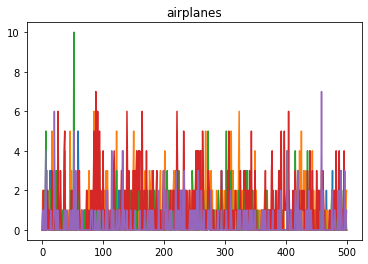

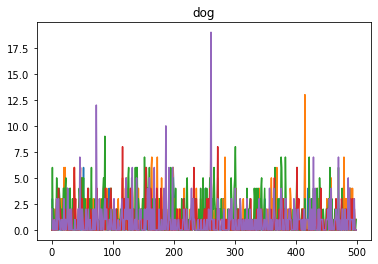

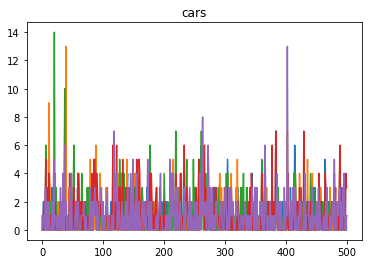

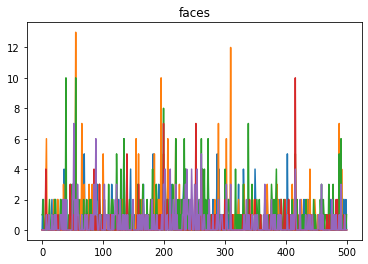

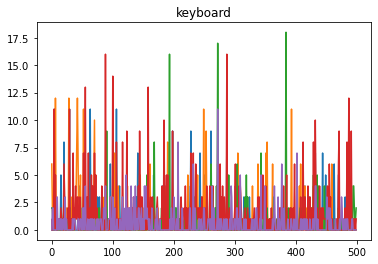

In [28]:
# Visualize the result by merging the histogram of images belonging same class
for key, value in train_histogram.items():
    plt.figure()
    plt.title(f"{key}")
    for idx, img in enumerate(value):
        plt.plot(img)

### Step 3.3 : Visualize some image patches that are assigned to the same codeword.

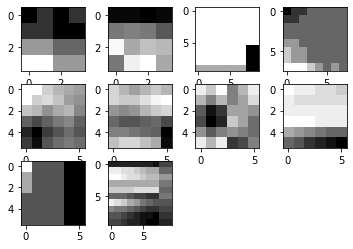

In [32]:
def plot_patches(patch_list:list):
    count = len(patch_list) # number of patch
    n_rows = int(np.ceil((count//10 + 1)*1.5)) # at least 2 row
    plt.figure()
    for patch_id, i in enumerate(patch_list):
        plt.subplot(n_rows, int(np.ceil(count/n_rows)), patch_id + 1)
        plt.imshow(i)



# input a key_point and image, then calculate the region that the key_point describe
def cut_img(kp, image):
    radius = int(np.round(kp.size))
    pt = kp.pt
    x = int(round(pt[0]))
    y = int(round(pt[1]))
    left = max(0, x-radius)
    high = min(len(image[0]), y + radius)
    right = min(len(image), x + radius)
    low = max(0, y-radius)
    return image[left: right, low: high]


'''
    visualize_number: an int between 0 to 20, visualize a number between 0 to 20 image patches in same code word.
    :return a list of image patches that are assigned to the same codeword.
'''
def visualize_patches(descriptors, keypoint_vectors, centers, visualize_number, dataset):
    patch_list = []

    if visualize_number > 20: visualize_number = 20

    # Random Pick a center
    sample_center = random.choice(centers)
    visual_count = 0
    for img_class, descriptor_value in descriptors.items():
        for img_idx, image in enumerate(descriptor_value):
            # similar to find_index
            for feature_idx, each_feature in enumerate(image):
                count = 0
                ind = 0
                for i in range(len(centers)):
                    if i == 0:
                        count = distance.euclidean(each_feature, centers[i])
                    else:
                        dist = distance.euclidean(each_feature, centers[i])
                        if dist < count:
                            count = dist
                            ind = i
                # check if it is equal to sample center
                if (centers[ind] == sample_center).all():
                    # get keypoint by mapping the index of descriptors
                    key_point = keypoint_vectors[img_class][img_idx][feature_idx]
                    # get img from dataset by mapping the index
                    image = dataset[img_class][img_idx]
                    img_show = cut_img(key_point, image)
                    patch_list.append(img_show)
                    visual_count += 1
                if visual_count >= visualize_number: return patch_list
    return patch_list

image_patches = visualize_patches(train_des_by_class, train_kp_by_class, words, 10, dataset=train_set)
plot_patches(image_patches)

# Inference Process
## Step 4: Classification

In [33]:
# 1-NN algorithm. We use this for predict the class of test images.
# Takes 2 parameters. images is the feature vectors of train images and tests is the feature vectors of test images
# Returns an array that holds number of test images, number of correctly predicted images and records of class based images respectively
def knn(images, tests):
    num_test = 0
    correct_predict = 0
    class_based = {}

    for test_key, test_val in tests.items():
        class_based[test_key] = [0, 0] # [correct, all]
        for tst in test_val:
            predict_start = 0
            #print(test_key)
            minimum = 0
            key = "a" #predicted
            for train_key, train_val in images.items():
                for train in train_val:
                    if(predict_start == 0):
                        minimum = distance.euclidean(tst, train)
                        #minimum = L1_dist(tst,train)
                        key = train_key
                        predict_start += 1
                    else:
                        dist = distance.euclidean(tst, train)
                        #dist = L1_dist(tst,train)
                        if(dist < minimum):
                            minimum = dist
                            key = train_key

            if(test_key == key):
                correct_predict += 1
                class_based[test_key][0] += 1
            num_test += 1
            class_based[test_key][1] += 1
            #print(minimum)
    return [num_test, correct_predict, class_based]

# Call the knn function
results_bowl = knn(train_histogram, test_histogram)
results_bowl

[5,
 1,
 {'airplanes': [1, 1],
  'dog': [0, 1],
  'cars': [0, 1],
  'faces': [0, 1],
  'keyboard': [0, 1]}]

In [31]:
# Calculates the average accuracy and class based accuracies.
def accuracy(results):
    avg_accuracy = (results[1] / results[0]) * 100
    print("Average accuracy: %" + str(avg_accuracy))
    print("\nClass based accuracies: \n")
    for key,value in results[2].items():
        acc = (value[0] / value[1]) * 100
        print(key + " : %" + str(acc))

# Calculates the accuracies and write the results to the console.
accuracy(results_bowl)

Average accuracy: %20.0

Class based accuracies: 

airplanes : %100.0
dog : %0.0
cars : %0.0
faces : %0.0
keyboard : %0.0
